# Определение ZDNA с помощью CNN

Импортируем нужные библиотеки

In [1]:
import torch
from torch import nn
import pandas as pd

Скачиваем данные:
1. Участки, полученные мной в ДЗ-1
2. ZDNA -- объединённые участки ZDNA (z-hunt и deep-z)
3. Последовательность ДНК всех хромосом

Данные скачиваем, архив с ДНК распаковываем.

In [2]:
!wget https://raw.githubusercontent.com/ShishckovA/hse21_H3F3A_ZDNA_human/master/data/H3F3A_hg19-intersect_with_ZDNA.bed -O H3F3A_ZDNA.bed
!wget https://raw.githubusercontent.com/ShishckovA/hse21_H3F3A_ZDNA_human/master/data/ZDNA-merge.bed -O ZDNA.bed
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/chromFa.tar.gz

!mkdir chromFA
!tar -zxvf chromFa.tar.gz -C chromFA

--2021-12-01 20:25:09--  https://raw.githubusercontent.com/ShishckovA/hse21_H3F3A_ZDNA_human/master/data/H3F3A_hg19-intersect_with_ZDNA.bed
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263500 (257K) [text/plain]
Saving to: ‘H3F3A_ZDNA.bed’

H3F3A_ZDNA.bed      100%[===================>] 257.32K  --.-KB/s    in 0.03s   

2021-12-01 20:25:09 (8.39 MB/s) - ‘H3F3A_ZDNA.bed’ saved [263500/263500]

--2021-12-01 20:25:09--  https://raw.githubusercontent.com/ShishckovA/hse21_H3F3A_ZDNA_human/master/data/ZDNA-merge.bed
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, await

In [3]:
!tail chromFA/chrX.fa

NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNN


Чтобы удобнее было работать с моими участками и участками ZDNA, создалим Dataframe-ы. Для всех хромосом загрузим их код в словарь data.

In [4]:
df = pd.read_csv("H3F3A_ZDNA.bed", header=None, sep="\t", names=["chr", "begin", "end"])
df_ZDNA = pd.read_csv("ZDNA.bed", header=None, sep="\t", names=["chr", "begin", "end"])

data = {}

for i in list(range(1, 23)) + ["X"]:
    file_name = f"chr{i}"
    with open(f"chromFA/{file_name}.fa") as f:
        data[file_name] =  "".join(f.read().split()[1:]).upper()

data["chr1"][15000000:15000020]

'CTGAAATTCAGAACGTCAGG'

Создадим данные про положительный класс --- возьмём все участки, полученные мной, которые состоят из A, T, G, C. 

In [5]:
pos = []

LEN = 1000

for chr, beg, end in df.values:
    mid = (end + beg) // 2
    start = end - LEN // 2
    end = end + LEN // 2
    if "N" not in data[chr][start:end]:
        pos.append(data[chr][start:end])

print(len(pos))

11018


А также отрицательный класс. Вырежем центральные 9/10 из каждой хромосомы и выберем случайные участки, которые не пересекаются с данными ZDNA (а значит и с моими данными). Отрицательного класса возьмём в 5 раз больше, чем положительного, так как отрицательного класса в целом больше, чем положительного.

In [6]:
import random, tqdm.notebook
random.seed(42)

df_by_chr = {
    chr: df_ZDNA[df_ZDNA["chr"] == chr] 
    for chr in data
}

def segment_ok(chr, l, r):
    have = (df_by_chr[chr]["end"] > l) & (r > df_by_chr[chr]["begin"])
    return not have.any()

def gen_part():
    chr = random.choice(list(data.keys()))
    ln = len(data[chr])
    cut_part = 1 / 10
    m = random.randint(int(ln * (cut_part / 2)), int(ln * (1 - cut_part / 2)))
    l = m - LEN // 2
    r = m + LEN // 2
    return chr, l, r

neg = []
N_neg = len(pos) * 5

for i in tqdm.notebook.tqdm(range(N_neg)):
    t = 0
    chr, l, r = gen_part()
    while (not segment_ok(chr, l, r)) or "N" in data[chr][l:r]:
        chr, l, r = gen_part()
    neg.append(data[chr][l:r])


  0%|          | 0/55090 [00:00<?, ?it/s]

Сделаем One-Hot encoding для полседовательности. Получим объект --- табличку размером 1000x4, в каждой строке ровно одна единица.

In [7]:
import numpy as np
from sklearn.metrics import f1_score

def convertLines(lines):
    newLines = np.zeros((len(lines), 4, len(lines[0])), dtype=int)
    is_good = np.ones(len(lines), dtype=bool)
    for i, line in enumerate(tqdm.notebook.tqdm(lines)):
        for j, c in enumerate(line.strip()):
            if c == 'A':
                v = [1,0,0,0]
            elif c == 'C':
                v = [0,1,0,0]
            elif c == 'G':
                v = [0,0,1,0]
            elif c == 'T':
                v = [0,0,0,1]
            else:
                raise ValueError()
            newLines[i, :, j] = np.array(v)
    return newLines


Разделим выборку на обучающую, валидационную и тестовую. Размер тренировочной сделаем 0.7, остальных --- по 0.15 от всего датасета.

In [8]:
from sklearn.model_selection import train_test_split

X = convertLines(pos + neg)
y = np.array([1] * len(pos) + [0] * len(neg))

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, shuffle=True, random_state=42, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, shuffle=True, random_state=42, test_size=0.5)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

  0%|          | 0/66108 [00:00<?, ?it/s]

((46275, 4, 1000),
 (46275,),
 (9916, 4, 1000),
 (9916,),
 (9917, 4, 1000),
 (9917,))

Я решил использовать PyTorch, так как с ним знаком лучше из-за курсов по глубинному обучению. За основу для некоторого кода взял записи с семинаров по PyTorch-у.

В этих ячейках определяю классы DataSet и Dataloader --- они помогают генерировать батчи для обучения сети.

In [9]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def preprocess(self, x):
        a = torch.from_numpy(x).float()
        return a

    def __getitem__(self, idx):
        return self.preprocess(self.x[idx]), self.y[idx]

    def __len__(self,):
        return len(self.x)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                    batch_size=256, shuffle=True,
                                    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                    batch_size=512, shuffle=True,
                                    num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                    batch_size=512, shuffle=True,
                                    num_workers=2)

Код для обучения одной эпохи, предсказания классов и полного обучения.

In [10]:

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()
    for (seq, labels) in train_dataloader:
        seq, labels = seq.to(device), labels.to(device)
        preds = model(seq)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def predict(model, test_dataloder, device="cuda:0"):
    model = model.to(device).eval()
    predicted_classes = []
    true_classes = []
    with torch.no_grad():
        for idx, (seq, labels) in enumerate((test_dataloder)): 
            seq, labels = seq.to(device), labels.to(device)
            preds = model(seq)
            predicted_classes.append(preds.argmax(1))
            true_classes.append(labels)
    predicted_classes = torch.cat(predicted_classes).flatten()
    true_classes = torch.cat(true_classes).flatten()
    return predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None, model_path_dir="/tmp/model"):
    model.to(device)
    print("EPOCHE\t|TRAIN ACCURACY\t|TRAIN F1_SCORE\t| TEST_ACCURACY\t| TEST F1_SCORE")
    print("-" * 72)
    train_history = []
    max_val_f1 = -1
    for epoch in range(1, n_epochs + 1):

        train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        y_prd, y_true = predict(model, train_dataloader, device)
        train_acc = (y_prd == y_true).float().mean().item()
        train_f1 = f1_score(y_true.cpu(), y_prd.cpu())
        y_prd, y_true = predict(model, val_dataloader, device)
        val_acc = (y_prd == y_true).float().mean().item()
        val_f1 = f1_score(y_true.cpu(), y_prd.cpu())
        is_best_model = "*" if val_f1 > max_val_f1 else ""
        print(f"{epoch}\t|     {train_acc:.4f}\t|     {train_f1:.4f}\t|     {val_acc:.4f}\t|     {val_f1:.4f}  {is_best_model}")
        if scheduler is not None:
            scheduler.step()
        train_history.append((train_acc, train_f1, val_acc, val_f1))
        if val_f1 > max_val_f1:
            max_val_f1 = val_f1
            model.save(model_path_dir)
    return np.array(train_history)

Модель взял не слишком сложную --- обычную последовательную модель с тремя блоками conv-maxpool. Число фильтров уменьшаю вглубь сети.

In [11]:
import os

class AlexeyNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = AlexeyNet.convLayer(4, 16, 5)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(5)
        self.do1 = nn.Dropout(0.3)

        self.conv2 = AlexeyNet.convLayer(16, 32, 5)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(4)
        self.do2 = nn.Dropout(0.4)

        self.conv3 = AlexeyNet.convLayer(32, 64, 3)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)

        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(1600, 2)

        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.pool1(out)
        out = self.do1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.pool2(out)
        out = self.do2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.pool3(out)

        out = self.flatten(out)

        out = self.fc(out)
        return out

    @staticmethod
    def convLayer(in_channels, out_channels, filter_width, zero_padding=True):
        return nn.Sequential(
            nn.Conv1d(
                in_channels,
                out_channels,
                filter_width,
                padding='same'
            ),
            nn.ReLU()
        )

    def save(self, path_dir="/tmp/model"):
        os.makedirs(path_dir, exist_ok=True)
        torch.save(self.state_dict(), f"{path_dir}/my_model.dict")

    def load(self, path_dir="/tmp/model"):
        self.load_state_dict(torch.load(f"{path_dir}/my_model.dict"))

model = AlexeyNet()

n_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model_path_dir = "/tmp/model"

Запуск обучения.

In [12]:
history = train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, model_path_dir)

EPOCHE	|TRAIN ACCURACY	|TRAIN F1_SCORE	| TEST_ACCURACY	| TEST F1_SCORE
------------------------------------------------------------------------
1	|     0.9084	|     0.7731	|     0.9000	|     0.7596  *
2	|     0.9150	|     0.7950	|     0.9083	|     0.7856  *
3	|     0.9054	|     0.7775	|     0.9021	|     0.7749  
4	|     0.9278	|     0.8207	|     0.9210	|     0.8102  *
5	|     0.9531	|     0.8755	|     0.9498	|     0.8703  *
6	|     0.9476	|     0.8632	|     0.9411	|     0.8512  
7	|     0.9716	|     0.9206	|     0.9705	|     0.9192  *
8	|     0.9634	|     0.9002	|     0.9635	|     0.9021  
9	|     0.9709	|     0.9191	|     0.9684	|     0.9142  
10	|     0.9784	|     0.9386	|     0.9778	|     0.9380  *
11	|     0.9735	|     0.9256	|     0.9717	|     0.9223  
12	|     0.9838	|     0.9530	|     0.9826	|     0.9505  *
13	|     0.9730	|     0.9245	|     0.9723	|     0.9237  
14	|     0.9779	|     0.9372	|     0.9758	|     0.9328  
15	|     0.9747	|     0.9288	|     0.9734	|     0.9266  
16	

Графики accuracy и f1_score на обучении:

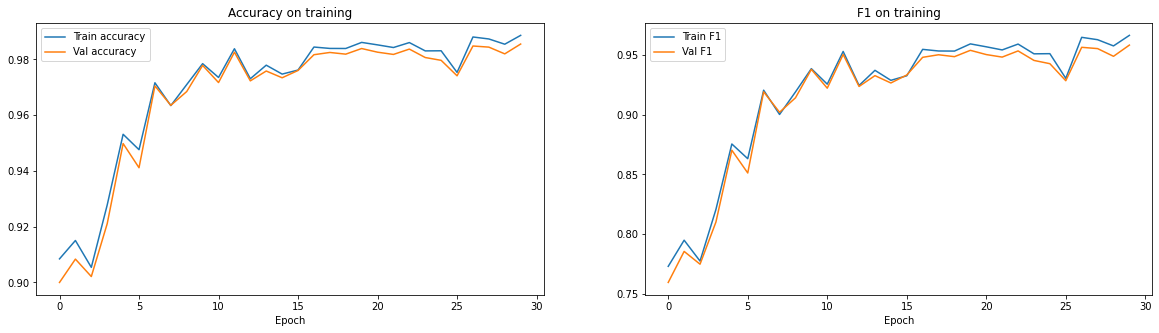

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(history[:, 0], label="Train accuracy")
ax[0].plot(history[:, 2], label="Val accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Accuracy on training")
ax[0].legend()

ax[1].plot(history[:, 1], label="Train F1")
ax[1].plot(history[:, 3], label="Val F1")
ax[1].set_xlabel("Epoch")
ax[1].set_title("F1 on training")
ax[1].legend();

Итоговое качество:

In [14]:
print("Last epoch model:")
y_pred, y_true = predict(model, test_dataloader, device)
print(f"Test accuracy: {(y_pred == y_true).float().mean().item():.4f}")
print(f"Test f1_score: {f1_score(y_true.cpu(), y_pred.cpu()):.4f}")

Last epoch model:
Test accuracy: 0.9861
Test f1_score: 0.9582


In [15]:
print("Best model:")
model.load(model_path_dir)
y_pred, y_true = predict(model, test_dataloader, device)
print(f"Test accuracy: {(y_pred == y_true).float().mean().item():.4f}")
print(f"Test f1_score: {f1_score(y_true.cpu(), y_pred.cpu()):.4f}")

Best model:
Test accuracy: 0.9861
Test f1_score: 0.9582
